In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import scipy.ndimage

import seaborn as sns
sns.set_style('white')
sns.set_context("notebook") #[poster, paper, talk, notebook]

In [ ]:
#lidar data (3k)

In [2]:
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc' #BSU
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow.where(ds.snow>=0) #all snow >= zero
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

In [ ]:
#terrain data (whole>3k) -- open whole, use ds.mask==1 and you don't have to take slices!

In [3]:
fpath = '/Users/meganmason491/Documents/research/sierra/data/terrain/*flipped*.nc' #BSU
# fpath = '' #mac

ts=xr.open_mfdataset(fpath, 
                     concat_dim=None, 
                     combine='nested', 
                     chunks={'x':1000, 'y':1000}, 
                     parallel=True) 
ts = ts.where(ds.mask==1)
ts.close()

//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
//anaconda3/envs/data_analysis/lib/python3.6/_collections_ab

<function matplotlib.pyplot.show(*args, **kw)>

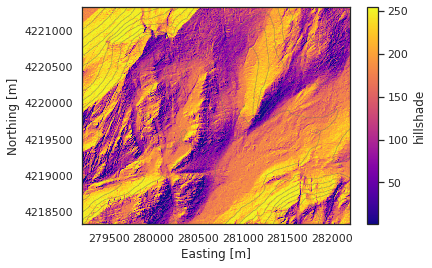

In [4]:
#quick plot
levels_50=np.linspace(1500,4000,50)
ts.hillshade.plot.imshow(x='x', y='y', cmap='plasma', cbar_kwargs={'label': 'hillshade'})
ds.dem.plot.contour(x='x', y='y', levels=levels_50, colors='dimgray', linewidths=.45, alpha=.7)
plt.show

In [21]:
#### functions

In [5]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=30, cmap='Blues', vmax=300):
    plt.figure(figsize=(10, 8))
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=vmax, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def plot_dem(ds, title, ctour_int=5, cmap='gray', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    levels = np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int)
    h = ds.dem.plot.imshow(x='x', y='y', cmap=cmap, alpha=.9, cbar_kwargs={'label': 'Elevation [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{} \n{}'.format(title))
    plt.tight_layout()

    
def plot_veg_hgt(ds, title, ctour_int=5, cmap='Greens', ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #3000 m
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    v = ds.veg.plot.imshow(x='x', y='y', cmap=cmap, alpha=.7, vmax=30, cbar_kwargs={'label': 'Vegetation Height [m]'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()


def plot_aspect(ts, title, slp_filter=10, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    lvls = [0, 45, 90, 135, 180, 225, 270, 315, 360]
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #3000 m
    # labels = ['North', '', 'East', '', 'South', '', 'West'] #CANT MAKE THIS WORK, would be nice to lable cbar
    s_gt10 = ts.where(ts.slope>=slp_filter) #eliminate aspects where the slope is <10 deg
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    a = s_gt10.aspect.plot.imshow(x='x', y='y', 
                                 colors= ['black','salmon','salmon','navajowhite','navajowhite', 'rebeccapurple','rebeccapurple','black'], 
                                 levels=lvls,
                                 alpha=.65,
                                 cbar_kwargs={'label': 'Aspect'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()

    
def plot_slope(ts, title, s_gt=15, ctour_int=5, ctour_lines='k'):
    plt.figure(figsize=(10, 8))
    #set up
    levels = np.around(np.arange(ds.dem.min().values, ds.dem.max().values, ctour_int), -2) #3000 m
    s_gt15 = ts.slope.where(ts.slope>s_gt)
    #plot
    h = ts.hillshade.plot.imshow(x='x',y='y', cmap='gray', alpha=1, add_colorbar=False)
    s = s_gt15.plot.imshow(x='x', y='y', 
                                 cmap='Wistia', 
                                 alpha=.65,
                                 cbar_kwargs={'label': 'slope'})
    c = ds.dem.plot.contour(x='x',y='y', levels=levels, colors=ctour_lines, linewidths=.75)
    plt.clabel(c, levels, fmt='%1.0f')
    plt.title('{}'.format(title))
    plt.tight_layout()


def plot_snow_series(ds, title, time=slice(2,51,5), col_wrap=5, cmap='Blues', vmax=300):
    plt.figure(figsize=(25, 20))
    s = ds.isel(time=time).snow.plot(x='x', y='y', col='time', 
                                     col_wrap=col_wrap,
                                     cmap=cmap, vmax=vmax, 
                                     cbar_kwargs={'label': 'Snow Depth [cm]'}, size=8)

def z_score(ds, time=slice(1,51,1), exclude_zeros=True):
    ds = ds.isel(time=time)
    x_gt0 = ds.snow.where(ds.snow>0) #snow depth > 0cm
    
    if exclude_zeros is True:
        return (ds.snow - x_gt0.mean(dim=('x','y')) / x_gt0.std(dim=('x','y')))
    else: 
        return (ds.snow - ds.snow.mean(dim=('x','y')) / ds.snow.std(dim=('x','y')))
  

In [23]:
### main script

<Figure size 1800x1440 with 0 Axes>

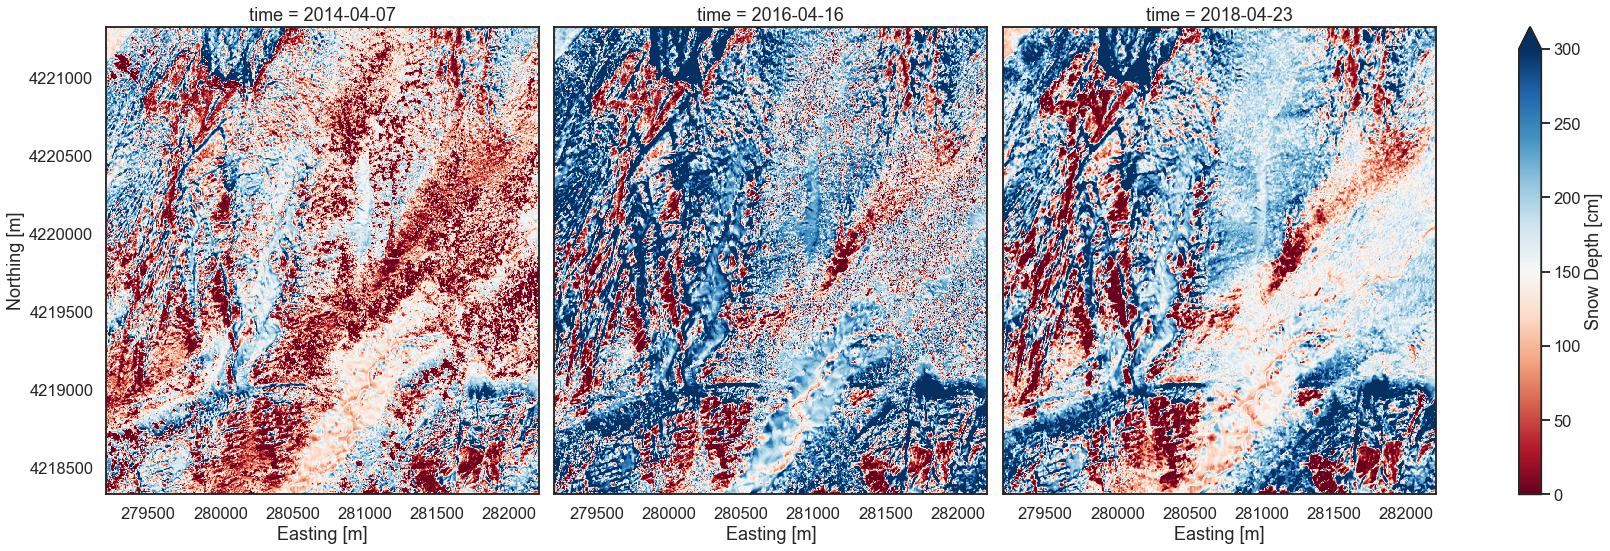

In [98]:
stns_longname = 'Acker Peak and Meadow'
stns_lc = '3k'
dx, dy = subregion_size(ds) #subregion size -- used in figure naming

sns.set_style('white') # set up seaborn defaults (warnings w/o inside loop..?)
sns.set_context("talk")

# print('mean', str(int(np.nanmean(ds.snow[30])))) #hard coded....
# print('std', str(int(np.nanstd(ds.snow[30]))))

# plot_sd(ds, title=stns_longname, vmax=400)
# plt.savefig('../figs/{}_sno_{}m.png'.format(stns_lc, int(dx)), dpi=300)

# plot_veg_hgt(ds, title=stns_longname, ctour_int=100) #plot veg of subregion (use 50 for 1000m)
# plt.savefig('../figs/{}_veg_{}m.png'.format(stns_lc, int(dx+3)), dpi=300)

# plot_aspect(ts, title=stns_longname, ctour_int=100)
# plt.savefig('../figs/{}_asp_{}m.png'.format(stns_lc, int(dx+3)), dpi=300)

# plot_slope(ts, title=stns_longname, ctour_int=100)
# plt.savefig('../figs/{}_slp_{}m.png'.format(stns_lc, int(dx+3)), dpi=300)


plot_snow_series(ds, title=stns_longname, time=[7,30,49], col_wrap=3, cmap='RdBu', vmax=300) #slice(1,51,10) [0,7,18,30,42,49]
plt.savefig('../figs/{}_sno_series{}m.png'.format(stns_lc, int(dx+3)), dpi=300)

In [99]:
#### LOCAL MEAN

In [113]:
def subregion_size(ds):
    dx = ds.x.max().values - ds.x.min().values
    dy = ds.y.max().values - ds.y.min().values
    return dx, dy


def plot_sd(ds, title, time=31, cmap='Blues', vmax=300):
    s = ds.isel(time=time)
    x_gt0 = s.snow.where(s.snow>0)
    x_gt0.plot.imshow(x='x', y='y', cmap=cmap, vmax=vmax, cbar_kwargs={'label': 'Snow Depth [cm]'})
    plt.tight_layout()

    
def kernel(n):
    # create mean filter 
    k = np.ones((n,n)) * 1./n**2
    return k

def smooth_over_grid(ds, k, time=31):
    s = ds.isel(time=time)
    smoothed = scipy.ndimage.convolve(s.snow, k)
    return smoothed

In [114]:
dx_input = 3000
flist = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_3km_subregion.nc'
flist = [flist]

In [115]:
stns = ['DAN','SLI','TUM'] #could make dict so it's always connected to the file, but shortcut is to do sorted(glob.glob) -- ie always loads in same order :/
stns_lc = ['dan','sli','tum']
stns_longname = ['Dana Meadow', 'Slide Canyon', 'Tuolumne Meadow']

k = kernel(50)

def smoother(f):
    # input (f): file
    # returns (smoothed_ds): xarray dataframe with smoothed snow layer
    
    ds = xr.open_dataset(f)#; ds.close() #open lidar snow depth DataSet in Xarray -- ds
    smooth_holder = np.zeros((51, 1000, 1000))
    smoothed_ds = ds.copy()
    for t in range(51):
           
        #grab a single time step
        subds = ds.isel(time=t).snow
        # apply the mean smoother filter 
        smooth_holder[t,:,:] = scipy.ndimage.convolve(subds, k)
        
    # done looping through time 
    # append the smoothed numpy ndarray to the newly copied xarray dataframe
    smoothed_ds['smoothed_snow'] = (('time','y','x'), smooth_holder)
    return smoothed_ds

list_of_smoothed_datasets = []
for f in flist:
    list_of_smoothed_datasets.append(smoother(f))


In [116]:
[ds1] = list_of_smoothed_datasets
print(type(ds1))

xarray.core.dataset.Dataset


Acker Peak and Meadow


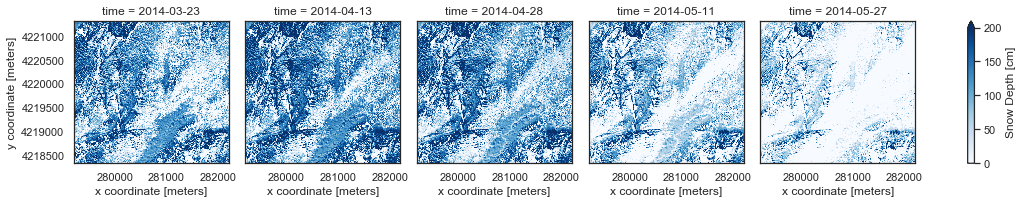

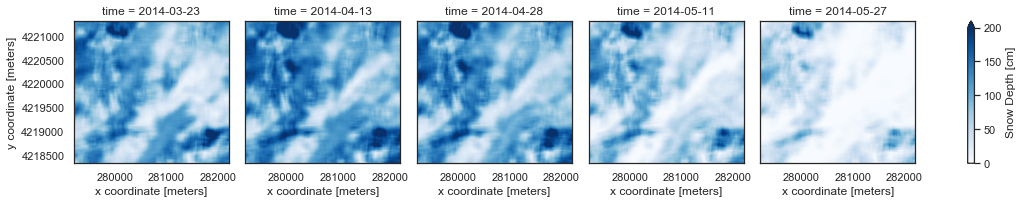

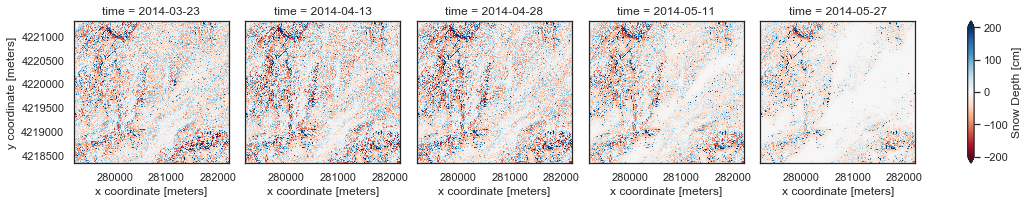

In [118]:
print('Acker Peak and Meadow')
#raw
ds1_=ds1.isel(time=slice(6,16,2))
ds1_.snow.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='Blues', vmax=200, cbar_kwargs={'label': 'Snow Depth [cm]'}); #plt.show()
plt.savefig('../figs/ack_raw_ex.png', dpi=300)
#smoothed
ds1_=ds1.isel(time=slice(6,16,2))
ds1_.smoothed_snow.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='Blues', vmax=200, cbar_kwargs={'label': 'Snow Depth [cm]'}); #plt.show()
plt.savefig('../figs/ack_smooth_150m_ex.png', dpi=300)
#differenced
diff = ds1_.snow - ds1_.smoothed_snow
diff.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='RdBu', vmax=200, cbar_kwargs={'label': 'Snow Depth [cm]'}); #plt.show()
plt.savefig('../figs/ack_diff_ex.png', dpi=300)